# Face detection on Tagesschau Videos

## Install
- pip install deepface
- pip install matplotlib==3.1.3

## Folder structure
- videos
  - video_0.mp4
  - video_1.mp4
  - ...
- frames
  - video_0
    - frame_0.jpg
    - frame_1.jpg
    - ...
  - ...
- faces
  - video_0
    - face_0.jpg
    - face_1.jpg
    - ...
  - ...

In [ ]:
# Install deepface
!pip install deepface

# Install matplotlib
!pip install matplotlib==3.1.3

In [ ]:
# Imports
import cv2
import os
import shutil
import matplotlib.pyplot as plt
import cv2

from matplotlib import image as mpimg
from glob import glob
from deepface import DeepFace
from deepface.commons import distance as dst

In [ ]:
# Directory names
frames_dirname = 'frames'
videos_dirname = 'videos'
faces_dirname = 'faces'
unique_faces_dirname = 'unique_faces'

## Step 1: Extract frames from videos

In [ ]:
# Create folder for frames (delete if already exists)
if os.path.exists(frames_dirname):
    shutil.rmtree(f'./{frames_dirname}')
os.mkdir(frames_dirname)

# Saves frames from a video
# - path: the path to the video
# - rate: the frame saving rate
def extractFramesFromVideo(video_path, rate, frames_path):
    # Get name of video
    video_full_name = os.path.basename(video_path)
    video_name = os.path.splitext(video_full_name)[0]
    print(video_name)

    # Create subfolder for video specific frames, e.g. 'frames/video_0/'
    video_frames_path = os.path.join(frames_path, video_name)
    os.mkdir(video_frames_path)

    # Open the video
    cap = cv2.VideoCapture(video_path)

    # Check if the video is opened
    if not cap.isOpened():
        print('Das Video konnte nicht geöffnet werden.')

    # Set the frame counter to 0
    frame_counter = 0

    # Read the video frame by frame
    while True:
        ret, frame = cap.read()

        # Check if we reached the end of the video
        if not ret:
            break

        # Save the frame
        if frame_counter % rate == 0:
            save_path = f'./{frames_path}/{video_name}/frame_{frame_counter//rate}.jpg'
            cv2.imwrite(save_path, frame)

        frame_counter += 1

    # Release the video capture object
    cap.release()

frame_save_rate = 24;

# Iterate over all videos in /videos and extract frames
for file in glob('videos/*'):
    if file.endswith('.mp4'):
        extractFramesFromVideo(file, frame_save_rate, frames_dirname)

## Step 2: Detect faces in videos using DeepFace



In [ ]:
# Displays the detected faces
# - faces: the detected faces
def displayFaces(faces):
  facesCount = len(faces)
  if facesCount == 1:
    # Show face in simple plot
    face = faces[0]['face']
    plt.figure()
    plt.imshow(face)
    plt.axis('off')
    plt.show()
  else:
    # Show faces in subplot
    fig, axs = plt.subplots(1, len(faces), figsize = (15, 10))
    for i, b in enumerate(faces):
      face = faces[i]['face']
      axs[i].imshow(face)
      axs[i].axis('off')
    plt.show() 

In [ ]:
# Saves faces to files
# - dirname: the folder name where images get saved
# - frame: the current frame number (if multiple faces per frame got detected)
# - faces: the detected faces
def saveFacesToFiles(dirname, frame, faces):
  for i, f in enumerate(faces):
    face = f['face']
    path = f'./{dirname}/face_{frame}_{i}.jpg'

    # Color scale image
    face = cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
    face = cv2.convertScaleAbs(face, alpha=(255.0))

    # Save image
    cv2.imwrite(path, face)
    print(f'Saved face to {path}')

In [ ]:
# Create folder for all faces (delete if already exists)
if os.path.exists(faces_dirname):
  shutil.rmtree(f'./{faces_dirname}')
os.mkdir(faces_dirname)

for subfolder in os.listdir(frames_dirname):
  subfolder_path = os.path.join(frames_dirname, subfolder)
  if os.path.isdir(subfolder_path):
    # Get frames and sort by modification time
    frames = sorted(glob(f'{subfolder_path}/*'), key=os.path.getmtime)

    # Only for testing with less frames 
    # first_ten_frames = frames[80:94]

    # Create subfolder for video specific faces e.g. 'faces/video_0/'
    video_faces_path = os.path.join(faces_dirname, subfolder)
    os.mkdir(video_faces_path)

    for i, frame in enumerate(frames):
      try:
        # Detect face using DeepFace
        faces = DeepFace.extract_faces(frame)
        print(f'Detected {len(faces)} face(s) in {frame}')
        saveFacesToFiles(video_faces_path, i, faces)
        displayFaces(faces)

      except:
        print(f'Could not detect any faces in {frame}')
        pass

## Step 3: Count faces

In [52]:
# Display face counts
# - face_counts: a map containing embeddings and counts
def displayFaceCounts(face_counts):
  fig, axs = plt.subplots(1, len(face_counts), figsize = (15, 10))
  for i, face in enumerate(face_counts):
    count = face_counts[face]
    image = mpimg.imread(face)
    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title(f'{count} time(s)')
  plt.show


Analyzing faces/video_1/face_0_0.jpg
New face faces/video_1/face_0_0.jpg

Analyzing faces/video_1/face_1_0.jpg
Comparing faces/video_1/face_1_0.jpg and faces/video_1/face_0_0.jpg
faces/video_1/face_1_0.jpg is equal to faces/video_1/face_0_0.jpg

Analyzing faces/video_1/face_2_0.jpg
Comparing faces/video_1/face_2_0.jpg and faces/video_1/face_0_0.jpg
New face faces/video_1/face_2_0.jpg

Analyzing faces/video_1/face_3_0.jpg
Comparing faces/video_1/face_3_0.jpg and faces/video_1/face_0_0.jpg
faces/video_1/face_3_0.jpg is equal to faces/video_1/face_0_0.jpg

Analyzing faces/video_1/face_4_0.jpg
Comparing faces/video_1/face_4_0.jpg and faces/video_1/face_0_0.jpg
faces/video_1/face_4_0.jpg is equal to faces/video_1/face_0_0.jpg

Analyzing faces/video_1/face_5_0.jpg
Comparing faces/video_1/face_5_0.jpg and faces/video_1/face_0_0.jpg
faces/video_1/face_5_0.jpg is equal to faces/video_1/face_0_0.jpg

Analyzing faces/video_1/face_6_0.jpg
Comparing faces/video_1/face_6_0.jpg and faces/video_1/fac

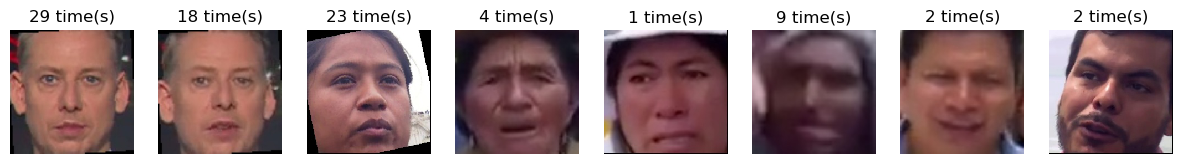

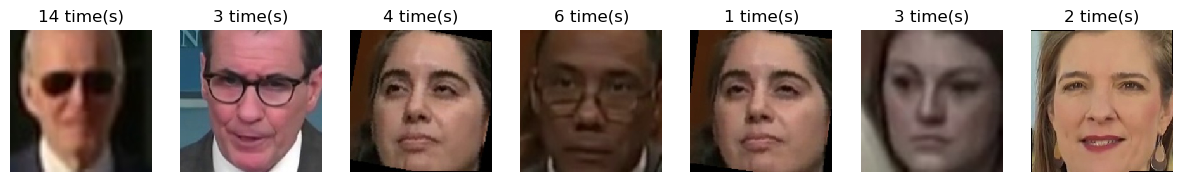

In [53]:
# Create folder for unique faces (delete if already exists)
if os.path.exists(unique_faces_dirname):
  shutil.rmtree(f'./{unique_faces_dirname}')
os.mkdir(unique_faces_dirname)

for subfolder in os.listdir(faces_dirname):
  subfolder_path = os.path.join(faces_dirname, subfolder)
  if os.path.isdir(subfolder_path):
    # Create subfolder for video specific unique faces e.g. 'unique_faces/video_0/'
    video_unique_faces_path = os.path.join(unique_faces_dirname, subfolder)
    os.mkdir(video_unique_faces_path)

    # embedding : count
    face_counts = {}

    # Get faces and sort by modification time
    faces = sorted(glob(f'{subfolder_path}/*'), key=os.path.getmtime)

    for i, face in enumerate(faces):
      print('')
      print(f'Analyzing {face}')
      # The first face is always new
      if i == 0:
        print(f'New face {face}')
        face_counts[face] = 1
        # Copy unique face to 'unique_faces/'
        shutil.copy(face, video_unique_faces_path)
      else:
        try:
          is_new_face = True
          # Go through all detected unique faces
          for unique_face in list(face_counts.keys()):
            print(f'Comparing {face} and {unique_face}')

            # Compare the new face with the unique face
            verify = DeepFace.verify(unique_face, face, distance_metric='cosine')
            if verify['verified'] == True:
              # The new face and the unique face are the same person
              # Set is_new_face to false and increase the counter
              is_new_face = False
              print(f'{face} is equal to {unique_face}')
              face_counts[unique_face] += 1
              break
          
          # We got a new face/person
          if is_new_face == True:
            print(f'New face {face}')
            face_counts[face] = 1

            # Copy unique face to 'unique_faces/'
            shutil.copy(face, video_unique_faces_path)

        except Exception as e:
          print(e)
          pass

    displayFaceCounts(face_counts)